In [84]:
from pathlib import Path
from typing import Tuple, List
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

import matplotlib.pyplot as plt


In [182]:
HERE = Path.cwd()

PROJECT_ROOT = HERE.parents[1]
DATA_RAW = PROJECT_ROOT / "data_files"
DATA_PROC = HERE / "processed_data"
MASTER_PATH = DATA_PROC / "melt_panel_master.csv"

# Load data + NA check

In [183]:
RANDOM_STATE = 42

def prepare_df(
    master_path: Path = MASTER_PATH,
    pos_quantile: float = 0.75,
) -> Tuple[pd.DataFrame, float]:
    """
    1. Drop melt rate NaN rows -> Main Target
    2. Set y_high_melt=0.75
    3. NANs double check: dorpna
    """
    df = pd.read_csv(master_path)
    df = df.dropna(subset=["melt_rate"])

    threshold = df["melt_rate"].quantile(pos_quantile)
    df["y_high_melt"] = (df["melt_rate"] >= threshold).astype(int)

    print(f"High-melt threshold at quantile {pos_quantile:.2f}: {threshold:.3f}")
    print("Overall class balance:")
    print(df["y_high_melt"].value_counts(normalize=True))

    target_col = "y_high_melt"
    drop_cols = [
        target_col,
        "melt_rate",
        "melt_count",
        "n_app",
        "n_admit",
        "n_enroll",
        "cc_name",
        "uc_campus",
    ]
    feature_cols = [c for c in df.columns if c not in drop_cols]
    X = df[feature_cols]

    mask = df["year"].notna()
    nan_row_mask = X.isna().any(axis=1)

    n_total = X[mask].shape[0]
    n_nan_rows = (mask & nan_row_mask).sum()
    n_after = (mask & ~nan_row_mask).sum()

    print("\n===== Missing summary (feature space, all years) =====")
    print(f"Total rows (year not NA): {n_total}")
    print(f"Rows with >=1 NaN in features: {n_nan_rows}")
    print(f"Rows remaining after dropna(): {n_after}")

    df_clean = df.loc[mask & ~nan_row_mask].copy()
    print(f"Rows kept for modeling after missing handling: {df_clean.shape[0]}")

    return df_clean, threshold

# Model session

## Split

In [184]:
def make_splits(
    df: pd.DataFrame,
    train_end_year: int = 2018,
    main_test_year: int = 2019,
    covid_start_year: int = 2020,
):
    """
    - Train: year <= train_end_year
    - Main test: year == main_test_year
    - COVID/post-COVID: year >= covid_start_year
    """
    target_col = "y_high_melt"
    drop_cols = [
        target_col,
        "melt_rate",
        "melt_count",
        "n_app",
        "n_admit",
        "n_enroll",
    ]

    feature_cols = [c for c in df.columns if c not in drop_cols]
    X = df[feature_cols]
    y = df[target_col]

    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    years = df["year"]

    train_mask = years <= train_end_year
    main_test_mask = years == main_test_year
    covid_mask = years >= covid_start_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_test_main, y_test_main = X[main_test_mask], y[main_test_mask]
    X_test_covid, y_test_covid = X[covid_mask], y[covid_mask]

    print("\n=== Split summary (after missing handling up front) ===")
    print("Train years:", sorted(df.loc[train_mask, "year"].unique()))
    print("Main test years:", sorted(df.loc[main_test_mask, "year"].unique()))
    print("COVID/post-COVID years:", sorted(df.loc[covid_mask, "year"].unique()))
    print(
        "Train size:", X_train.shape,
        " Main test size:", X_test_main.shape,
        " COVID size:", X_test_covid.shape,
    )

    return (
        X_train,
        y_train,
        X_test_main,
        y_test_main,
        X_test_covid,
        y_test_covid,
        numeric_cols,
        categorical_cols,
    )


def build_preprocessor(
    numeric_cols: List[str],
    categorical_cols: List[str],
) -> ColumnTransformer:
    """
    ColumnTransformer：
    - Numeric：StandardScaler
    - Categorical：OneHotEncoder
    """
    numeric_transformer = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols),
        ]
    )
    return preprocessor



def get_splits_and_preprocessor():
    """
    One-stop helper for training scripts.

    Returns:
    - X_train, y_train
    - X_test_main, y_test_main
    - X_test_covid, y_test_covid
    - preprocessor
    """
    df, threshold = prepare_df()

    (
        X_train,
        y_train,
        X_test_main,
        y_test_main,
        X_test_covid,
        y_test_covid,
        numeric_cols,
        categorical_cols,
    ) = make_splits(df)

    preprocessor = build_preprocessor(numeric_cols, categorical_cols)

    return (
        X_train,
        y_train,
        X_test_main,
        y_test_main,
        X_test_covid,
        y_test_covid,
        preprocessor,
        threshold,
    )


## Model func

In [185]:
def fit_glm(X_train, y_train, preprocessor):
    """
    GLM L2+balanced
    """
    base_model = LogisticRegression(
        penalty="l2",
        solver="saga",
        max_iter=5000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", base_model),
        ]
    )

    param_grid = {
        "model__C": [0.01, 0.1, 1.0, 10.0],
        "model__l1_ratio": [0.1, 0.5, 0.9],
    }

    clf = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
    )

    clf.fit(X_train, y_train)
    print("\n[GLM] Best params:", clf.best_params_)
    print("[GLM] Best CV AUC:", clf.best_score_)

    return clf.best_estimator_

In [186]:
def fit_rf(X_train, y_train, preprocessor):
    """
    Random Forest
    """
    base_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", base_model),
        ]
    )

    param_grid = {
        "model__max_depth": [5, 10, None],
        "model__min_samples_leaf": [5, 10, 20],
    }

    clf = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
    )

    clf.fit(X_train, y_train)
    print("\n[RF] Best params:", clf.best_params_)
    print("[RF] Best CV AUC:", clf.best_score_)

    return clf.best_estimator_

In [187]:
def evaluate_model(model, X, y, label="dataset"):
    """
    Print AUC, PR-AUC, confusion matrix, and classification report.
    """
    if X.shape[0] == 0:
        print(f"\n==== {label}: empty, skipped ====")
        return

    proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)

    auc = roc_auc_score(y, proba)
    ap = average_precision_score(y, proba)
    print(f"\n==== Performance on {label} ====")
    print(f"AUC:     {auc:.3f}")
    print(f"PR-AUC:  {ap:.3f}")
    print("Confusion matrix:\n", confusion_matrix(y, pred))
    print("Classification report:\n", classification_report(y, pred))


## Main

In [217]:
(
    X_train,
    y_train,
    X_test,
    y_test,
    X_covid,
    y_covid,
    preprocessor,
    threshold,
) = get_splits_and_preprocessor()

print(f"\nUsing high-melt threshold (quantile): {threshold:.3f}")


High-melt threshold at quantile 0.75: 0.864
Overall class balance:
y_high_melt
0    0.749688
1    0.250312
Name: proportion, dtype: float64

===== Missing summary (feature space, all years) =====
Total rows (year not NA): 17654
Rows with >=1 NaN in features: 267
Rows remaining after dropna(): 17387
Rows kept for modeling after missing handling: 17387

=== Split summary (after missing handling up front) ===
Train years: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Main test years: [2019]
COVID/post-COVID years: [2020, 2021, 2022, 2023, 2024]
Train size: (11692, 22)  Main test size: (917, 22)  COVID size: (4778, 22)

Using high-melt threshold (quantile): 0.864


In [218]:
glm_model = fit_glm(X_train, y_train, preprocessor)
evaluate_model(glm_model, X_test, y_test, label="L2: Main test (2019)")
evaluate_model(glm_model, X_covid, y_covid, label="L2: COVID/post-COVID (>=2020)")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\RoooC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(



[GLM] Best params: {'model__C': 0.1, 'model__l1_ratio': 0.1}
[GLM] Best CV AUC: 0.886557982436021

==== Performance on L2: Main test (2019) ====
AUC:     0.913
PR-AUC:  0.767
Confusion matrix:
 [[620 108]
 [ 39 150]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       728
           1       0.58      0.79      0.67       189

    accuracy                           0.84       917
   macro avg       0.76      0.82      0.78       917
weighted avg       0.87      0.84      0.85       917


==== Performance on L2: COVID/post-COVID (>=2020) ====
AUC:     0.902
PR-AUC:  0.782
Confusion matrix:
 [[2998  506]
 [ 278  996]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.88      3504
           1       0.66      0.78      0.72      1274

    accuracy                           0.84      4778
   macro avg       0.79      0.82      0.80      4778
wei

In [219]:
rf_model = fit_rf(X_train, y_train, preprocessor)
evaluate_model(rf_model, X_test, y_test, label="Main test (2019)")
evaluate_model(rf_model, X_covid, y_covid, label="COVID/post-COVID (>=2020)")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

[RF] Best params: {'model__max_depth': None, 'model__min_samples_leaf': 5}
[RF] Best CV AUC: 0.8940453827815595

==== Performance on Main test (2019) ====
AUC:     0.924
PR-AUC:  0.770
Confusion matrix:
 [[653  75]
 [ 45 144]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       728
           1       0.66      0.76      0.71       189

    accuracy                           0.87       917
   macro avg       0.80      0.83      0.81       917
weighted avg       0.88      0.87      0.87       917


==== Performance on COVID/post-COVID (>=2020) ====
AUC:     0.906
PR-AUC:  0.787
Confusion matrix:
 [[3228  276]
 [ 446  828]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      3504
           1       0.75      0.65      0.70      1274

    accuracy                           0.85  

In [220]:
results_main = X_test.copy()
results_main["y_true"] = y_test.values
results_main["glm_proba"] = glm_model.predict_proba(X_test)[:, 1]
results_main["rf_proba"] = rf_model.predict_proba(X_test)[:, 1]
results_main.to_csv(
    DATA_PROC / "melt_model_main_test_predictions.csv",
    index=False,
)

results_covid = X_covid.copy()
results_covid["y_true"] = y_covid.values
if X_covid.shape[0] > 0:
    results_covid["glm_proba"] = glm_model.predict_proba(X_covid)[:, 1]
    results_covid["rf_proba"] = rf_model.predict_proba(X_covid)[:, 1]
results_covid.to_csv(
    DATA_PROC / "melt_model_covid_predictions.csv",
    index=False,
)

print("Saved")

Saved


# Visuals + Interpretation

In [193]:
PRED_FILES: List[Path] = [
    DATA_PROC / "melt_model_main_test_predictions.csv",
    DATA_PROC / "melt_model_covid_predictions.csv",
]

PROBA_COL = "glm_proba"

HIGH_RISK_THRESHOLD = 0.6

## Heatmap

In [240]:
def load_predictions(pred_files: List[Path]) -> pd.DataFrame:
    """
    Load prediction
    """
    dfs = []
    for path in pred_files:
        df = pd.read_csv(path)
        dfs.append(df)

    pred = pd.concat(dfs, ignore_index=True)

    required_cols = {"cc_name", "uc_campus", "year", "y_true", PROBA_COL}
    missing = required_cols - set(pred.columns)
    if missing:
        raise ValueError(
            f"Missing required columns in prediction data: {missing}. "
            f"Make sure your prediction CSVs contain: {required_cols}"
        )

    return pred


def summarize_by_pair(pred: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate metrics
    and bring along average composition features.
    """
    df = pred.copy()
    df["high_pred_flag"] = (df[PROBA_COL] >= HIGH_RISK_THRESHOLD).astype(int)

    agg_dict = dict(
        true_high_share=("y_true", "mean"),
        mean_proba=(PROBA_COL, "mean"),
        high_pred_share=("high_pred_flag", "mean"),
        n_obs=("year", "count"),
        n_years=("year", "nunique"),
    )
    comp_cols = [
        "share_gender_female",
        "share_gender_male",
        "share_eth_african_american",
        "share_eth_american_indian",
        "share_eth_asian",
        "share_eth_hispanic__latinx",
        "share_eth_int'l",
        "share_eth_pacific_islander",
        "share_eth_white",
    ]
    for c in comp_cols:
        if c in df.columns:
            agg_dict[c] = (c, "mean")

    pair_summary = (
        df.groupby(["cc_name", "uc_campus"], as_index=False)
          .agg(**agg_dict)
          .sort_values(
              by=["true_high_share", "mean_proba"],
              ascending=[False, False],
          )
    )
    return pair_summary


def plot_cc_uc_heatmap(pair_summary: pd.DataFrame,
                       value_col: str = "mean_proba",
                       out_path: Path | None = None):
    heat = pair_summary.pivot(
        index="cc_name",
        columns="uc_campus",
        values=value_col,
    )

    row_order = heat.mean(axis=1).sort_values(ascending=True).index
    heat = heat.loc[row_order]

    data = heat.to_numpy()

    fig, ax = plt.subplots(figsize=(6, 10))
    im = ax.imshow(
        data,
        aspect="auto",
        origin="lower",
        cmap="Blues",
        vmin=0.0,
        vmax=1.0,
    )

    uc_names = heat.columns.to_list()
    ax.set_xticks(np.arange(len(uc_names)))
    ax.set_xticklabels(uc_names, rotation=45, ha="right", fontsize=8)

    ax.set_yticks([])
    ax.set_ylabel("")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(value_col)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300)
    print("Saved")


Saved


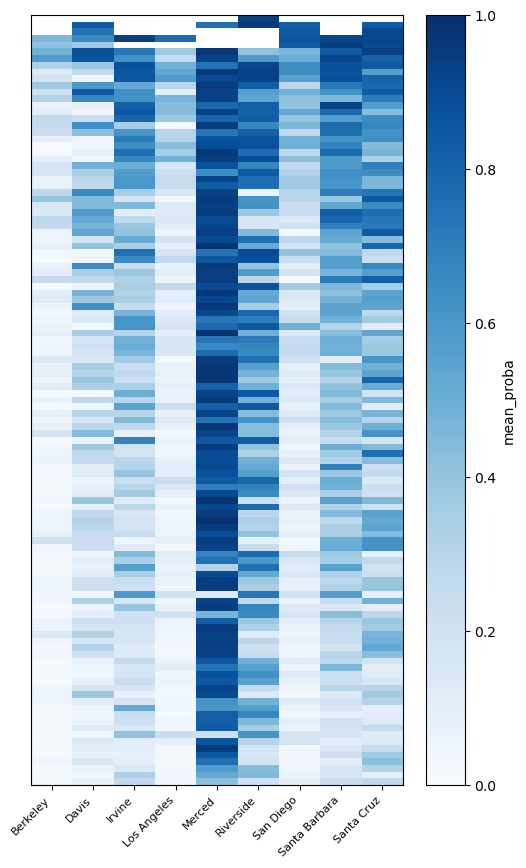

In [241]:
heatmap_out = DATA_PROC / "melt_cc_uc_heatmap.png"

plot_cc_uc_heatmap(
    pair_summary,
    value_col="mean_proba",
    out_path=heatmap_out,
)


## ROC

In [242]:
def save_roc_pr_curves(
    pred: pd.DataFrame,
    proba_col_glm: str = "glm_proba",
    proba_col_rf: str = "rf_proba",
    year_cond=None,
    title_prefix: str = "Main 2020",
    out_prefix=DATA_PROC / "glm_rf_main2020",
):
    df = pred.copy()
    if year_cond is not None:
        df = df.loc[year_cond].copy()

    y = df["y_true"].values
    p_glm = df[proba_col_glm].values
    p_rf = df[proba_col_rf].values

    # ROC
    fpr_glm, tpr_glm, _ = roc_curve(y, p_glm)
    fpr_rf, tpr_rf, _ = roc_curve(y, p_rf)

    fig_roc, ax_roc = plt.subplots(figsize=(5, 4))
    ax_roc.plot(fpr_glm, tpr_glm, label="GLM")
    ax_roc.plot(fpr_rf, tpr_rf, label="RF")
    ax_roc.plot([0, 1], [0, 1], "--", color="grey")
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"{title_prefix} ROC")
    ax_roc.legend()
    fig_roc.tight_layout()

    out_roc = out_prefix.with_name(out_prefix.name + "_roc.png")
    out_roc.parent.mkdir(parents=True, exist_ok=True)
    fig_roc.savefig(out_roc, dpi=300)
    plt.close(fig_roc)

    # PR
    prec_glm, rec_glm, _ = precision_recall_curve(y, p_glm)
    prec_rf, rec_rf, _ = precision_recall_curve(y, p_rf)

    fig_pr, ax_pr = plt.subplots(figsize=(5, 4))
    ax_pr.plot(rec_glm, prec_glm, label="GLM")
    ax_pr.plot(rec_rf, prec_rf, label="RF")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title(f"{title_prefix} PR curve")
    ax_pr.legend()
    fig_pr.tight_layout()

    out_pr = out_prefix.with_name(out_prefix.name + "_pr.png")
    fig_pr.savefig(out_pr, dpi=300)

    print("Saved")


Saved


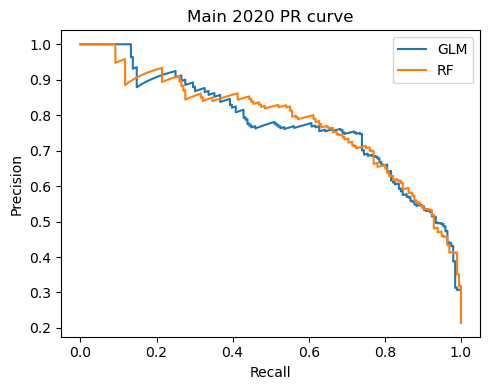

In [243]:
save_roc_pr_curves(pred,year_cond=(pred["year"] == 2020),)

## By UC - trend

In [245]:
def save_uc_trend(
    pred: pd.DataFrame,
    uc_name: str,
    proba_col: str = "glm_proba",
    out_dir: Path = DATA_PROC,  
):

    df = pred.loc[pred["uc_campus"] == uc_name].copy()

    if df.empty:
        print(f"No rows found for UC campus: {uc_name}")
        return

    year_summary = (
        df.groupby("year", as_index=False)
          .agg(
              true_high_share=("y_true", "mean"),
              mean_proba=(proba_col, "mean"),
          )
          .sort_values("year")
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(year_summary["year"], year_summary["true_high_share"],
            marker="o", label="Observed high-melt share")
    ax.plot(year_summary["year"], year_summary["mean_proba"],
            marker="o", label="Predicted risk")

    ax.axvline(2020, linestyle="--", color="grey", label="COVID onset")

    ax.set_xlabel("Year")
    ax.set_ylabel("Share / probability")
    ax.set_title(f"{uc_name}: high-melt trend over time")
    ax.legend()
    fig.tight_layout()

    out_path = out_dir / f"uc_trend_glm_{uc_name}.png"

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300)

    print("Saved:", out_path)

Saved: c:\Users\RoooC\Documents\GitHub\ucd-sta-221-project\ucd_sta_221_project\ml\q3_enrollment_melt\processed_data\uc_trend_glm_Davis.png


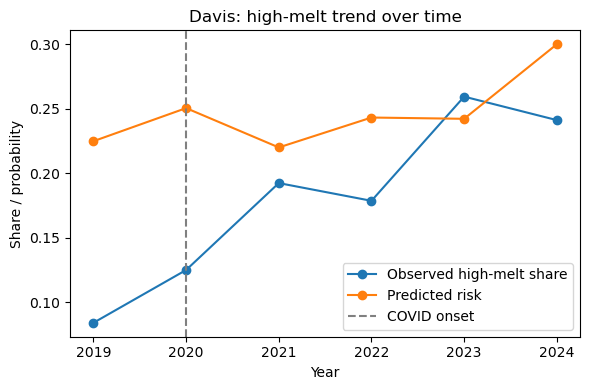

In [246]:
save_uc_trend(
    pred,
    uc_name="Davis",
)

Saved: c:\Users\RoooC\Documents\GitHub\ucd-sta-221-project\ucd_sta_221_project\ml\q3_enrollment_melt\processed_data\uc_trend_glm_Merced.png


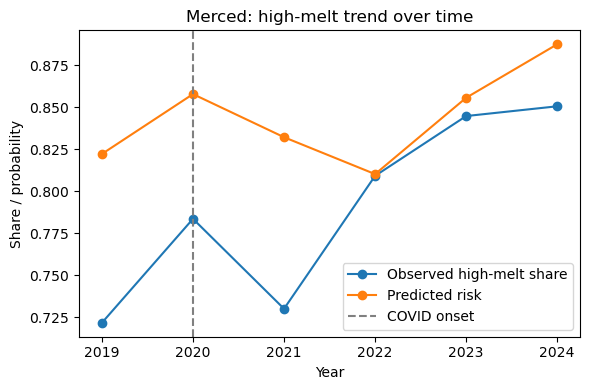

In [247]:
save_uc_trend(
    pred,
    uc_name="Merced",
)

## Driving distance

In [248]:
def save_all_distance_bins(
    pred: pd.DataFrame,
    value_col: str = "glm_proba",
    out_path: Path = DATA_PROC / "cc_uc_drive_hours.png",
):
    df = pred.dropna(subset=["cc_uc_drive_hours", value_col]).copy()

    bins = [0, 0.5, 1.5, 2.5, 3.5,4.5]
    labels = ["<0.5", "1.5–2.5", "2.5–3.5", "3.5-4.5",">4.5"]
    df["dist_bin"] = pd.cut(df["cc_uc_drive_hours"], bins=bins, labels=labels, right=False)

    g = (
        df.groupby("dist_bin", as_index=False)
          .agg(
              risk=(value_col, "mean"),
              n_obs=("y_true", "size"),
          )
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(g["dist_bin"], g["risk"])
    ax.set_xlabel("CC–UC distance (hours)")
    ax.set_ylabel("Predicted risk (mean proba)")
    ax.set_title("Predicted melt risk by hours bin (all campuses)")
    fig.tight_layout()

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300)
    print("Saved:", out_path)


C:\Users\RoooC\AppData\Local\Temp\ipykernel_3728\2266252095.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("dist_bin", as_index=False)


Saved: c:\Users\RoooC\Documents\GitHub\ucd-sta-221-project\ucd_sta_221_project\ml\q3_enrollment_melt\processed_data\cc_uc_drive_hours.png


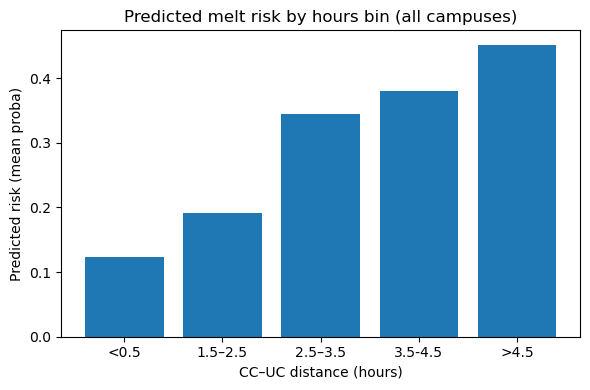

In [249]:
save_all_distance_bins(pred)
